# Importowanie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
import re

# Pandas Dataframe displaying options
pd.set_option('display.max_columns', None)

# Ładowanie danych
W `weather_data_from_wunderground.csv` znajdują się godzinowe dane pogodowe pozyskane ze strony wunderground.com dla Nowego Jorku.

W `Motor_Vehicle_Collisions_-_Crashes.csv` znajdują się dane o wypadkach w Nowym Jorku, plik został pozyskany ze strony https://www.kaggle.com/datasets/muzammilrizvi1/motor-vehicle-collisions-crashes

In [2]:
weather_data = pd.read_csv('weather_data_from_wunderground.csv', infer_datetime_format=True, parse_dates=['Timestamp'])
collision_data = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', low_memory=False, parse_dates={'TIMESTAMP':[0, 1]})

# Wstępna analiza zbiorów danych

Kolumny w `weather_data`:
+ Timestamp - czas odczytu danych pogodowych
+ Temperature - temperatura w stopniach Celsjusza
+ Dew Point - punkt rosy w stopniach Celsjusza
+ Humidity - wilgotność w %
+ Wind Speed - prędkość wiatru w km/h
+ Pressure - ciśnienie atmosferyczne w hPa
+ Precip. - opady w mm
+ Condition - warunki atmosferyczne

In [3]:
weather_data.head()


,Timestamp,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition
0,2012-07-02 23:00:00,28,13,41,15,1010.08,0.0,Partly Cloudy
1,2012-07-02 00:00:00,27,12,39,15,1009.78,0.0,Partly Cloudy
2,2012-07-02 01:00:00,27,12,40,11,1010.28,0.0,Fair
3,2012-07-02 02:00:00,25,13,48,13,1010.08,0.0,Fair
4,2012-07-02 03:00:00,25,13,46,0,1009.98,0.0,Fair


In [4]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    93142 non-null  datetime64[ns]
 1   Temperature  93142 non-null  int64         
 2   Dew Point    93142 non-null  int64         
 3   Humidity     93142 non-null  int64         
 4   Wind Speed   93142 non-null  int64         
 5   Pressure     93142 non-null  float64       
 6   Precip.      93142 non-null  float64       
 7   Condition    93142 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 5.7+ MB


In [5]:
weather_data.describe(include='all', datetime_is_numeric=True)

,Timestamp,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition
count,93142,93142.000000,93142.000000,93142.000000,93142.000000,93142.000000,93142.000000,93142
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25704
mean,2017-10-28 18:38:49.011616512,13.808014,5.400539,59.630113,17.010693,1015.868608,0.079591,NaN
min,2012-07-01 00:00:00,-17.000000,-27.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2015-03-01 10:15:00,6.000000,-3.000000,46.000000,11.000000,1011.130000,0.000000,NaN
50%,2017-10-28 13:30:00,14.000000,6.000000,58.000000,17.000000,1016.210000,0.000000,NaN
75%,2020-06-26 14:45:00,22.000000,14.000000,74.000000,22.000000,1021.280000,0.000000,NaN
max,2023-02-25 23:00:00,38.000000,26.000000,100.000000,91.000000,1043.620000,55.400000,NaN


Kolumny w `collision_data`:
+ TIMESTAMP - czas odczytu danych pogodowych
+ BOROUGH - okręg administracyjny miejsca wypadku
+ ZIP CODE - kod pocztowy miejsca wypadku
+ LATITUDE - szerokość geograficzna miejsca wypadku
+ LONGITUDE	- długość geograficzna miejsca wypadku
+ LOCATION - koordynaty geograficzne miejsca wypadku
+ ON STREET NAME - nazwa ulicy, na której doszło do wypadku
+ CROSS STREET NAME - nazwa najbliższej przecznicy w pobliżu miejsca wypadku
+ OFF STREET NAME - adres ulicy miejsca wypadku
+ NUMBER OF PERSONS INJURED	- liczba osób rannych w wypadku
+ NUMBER OF PERSONS KILLED - liczba ofiar śmiertelnych
+ NUMBER OF PEDESTRIANS INJURED	- liczba rannych przechodniów
+ NUMBER OF PEDESTRIANS KILLED - liczba ofiar śmiertelnych wśród przechodniów
+ NUMBER OF CYCLIST INJURED	- liczba rannych rowerzystów
+ NUMBER OF CYCLIST KILLED - liczba ofiar śmiertelnych wśród rowerzystów
+ NUMBER OF MOTORIST INJURED - liczba rannych kierowców 
+ NUMBER OF MOTORIST KILLED	- liczba ofiar śmiertelnych wśród kierowców
+ CONTRIBUTING FACTOR VEHICLE n	- czynnik powodujący wypadek dla danego pojazdu
+ COLLISION_ID - identyfikator wypadku
+ VEHICLE TYPE CODE n - typ danego pojazdu

In [6]:
collision_data.head()

,TIMESTAMP,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2021-09-11 02:39:00,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26 11:45:00,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2022-06-29 06:55:00,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,2021-09-11 09:35:00,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,2021-12-14 08:13:00,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [7]:
collision_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972121 entries, 0 to 1972120
Data columns (total 28 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   TIMESTAMP                      1972121 non-null  datetime64[ns]
 1   BOROUGH                        1359090 non-null  object        
 2   ZIP CODE                       1358854 non-null  object        
 3   LATITUDE                       1746093 non-null  float64       
 4   LONGITUDE                      1746093 non-null  float64       
 5   LOCATION                       1746093 non-null  object        
 6   ON STREET NAME                 1560271 non-null  object        
 7   CROSS STREET NAME              1240647 non-null  object        
 8   OFF STREET NAME                319479 non-null   object        
 9   NUMBER OF PERSONS INJURED      1972103 non-null  float64       
 10  NUMBER OF PERSONS KILLED       1972090 non-null  float

Przedział czasowy danych o wypadkach

In [8]:
collision_data['TIMESTAMP'].describe(datetime_is_numeric=True)

count                          1972121
mean     2017-03-24 08:48:56.814628352
min                2012-07-01 00:05:00
25%                2014-11-30 21:15:00
50%                2017-02-19 05:30:00
75%                2019-04-14 11:00:00
max                2023-02-25 23:50:00
Name: TIMESTAMP, dtype: object

Brakujące dane w zbiorze danych o wypadkach

In [9]:
def show_missing_values(dataframe):
    nulls = dataframe.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values(collision_data)

,Number,Percentage
VEHICLE TYPE CODE 5,1964039,99.590187
CONTRIBUTING FACTOR VEHICLE 5,1963795,99.577815
VEHICLE TYPE CODE 4,1942160,98.480773
CONTRIBUTING FACTOR VEHICLE 4,1941150,98.429559
VEHICLE TYPE CODE 3,1838042,93.201279
CONTRIBUTING FACTOR VEHICLE 3,1833347,92.963211
OFF STREET NAME,1652642,83.800233
CROSS STREET NAME,731474,37.090726
ZIP CODE,613267,31.096824
BOROUGH,613031,31.084857


# Wstępne przetwarzanie danych

Ze zbioru `collision_data` usunięte zostają kolumny niezwiązane z postawionym problemem.

In [10]:
collision_data.drop(columns=['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME','CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'], inplace=True, errors='ignore')

collision_data

,TIMESTAMP,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
0,2021-09-11 02:39:00,2.0,0.0,0,0,0,0,2,0
1,2022-03-26 11:45:00,1.0,0.0,0,0,0,0,1,0
2,2022-06-29 06:55:00,0.0,0.0,0,0,0,0,0,0
3,2021-09-11 09:35:00,0.0,0.0,0,0,0,0,0,0
4,2021-12-14 08:13:00,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1972116,2023-02-25 08:30:00,0.0,0.0,0,0,0,0,0,0
1972117,2023-02-24 08:00:00,1.0,0.0,1,0,0,0,0,0
1972118,2023-02-12 16:25:00,0.0,0.0,0,0,0,0,0,0
1972119,2023-02-15 11:00:00,0.0,0.0,0,0,0,0,0,0


# Rozwiązanie problemu brakujących danych

In [11]:
show_missing_values(collision_data)

,Number,Percentage
NUMBER OF PERSONS KILLED,31,0.001572
NUMBER OF PERSONS INJURED,18,0.000913


Kolumna 'NUMBER OF PERSONS KILLED' zawiera sumę wartości z kolumn 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED'.
Analogicznie kolumna 'NUMBER OF PERSONS INJURED' zawiera sumę wartości z kolumn 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED'.

In [12]:
collision_data['NUMBER OF PERSONS INJURED'] = collision_data.loc[:, ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']].sum(axis=1)
collision_data['NUMBER OF PERSONS KILLED'] = collision_data.loc[:, ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']].sum(axis=1)

show_missing_values(collision_data)

,Number,Percentage


# Podsumowanie danych

W celu rozwiązania problemu dane o wypadkach zostają zgrupowane według daty i przedziału godzinowego wynoszącego jedną godzinę. Następnie wartości w kolumnach dla danej grupy zostają zsumowane i dostawiona zostaje dodatkowa kolumna 'NUMBER OF ACCIDENTS' zawierająca liczbę wypadków dla danego przedziału czasowego.

In [13]:
collision_data['TIMESTAMP'] = collision_data['TIMESTAMP'].apply(lambda x: x.replace(minute=0, second=0))
collision_data.set_index('TIMESTAMP', inplace=True)

accidents = collision_data.groupby('TIMESTAMP').size().reset_index(name='NUMBER OF ACCIDENTS')

collision_data = collision_data.groupby('TIMESTAMP').sum()
collision_data = pd.merge(collision_data, accidents, on='TIMESTAMP')

Następnie dane o wypadkach zostają połączone z danymi pogodowymi na podstawie przedziału czasowego.

In [14]:
combined_data = pd.merge(weather_data, collision_data, left_on='Timestamp', right_on='TIMESTAMP')
combined_data.drop(columns='TIMESTAMP', inplace=True)
combined_data


,Timestamp,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,NUMBER OF ACCIDENTS
0,2012-07-02 23:00:00,28,13,41,15,1010.08,0.0,Partly Cloudy,8,0,2,0,0,0,6,0,14
1,2012-07-02 00:00:00,27,12,39,15,1009.78,0.0,Partly Cloudy,4,0,1,0,2,0,1,0,16
2,2012-07-02 01:00:00,27,12,40,11,1010.28,0.0,Fair,18,0,0,0,0,0,18,0,14
3,2012-07-02 02:00:00,25,13,48,13,1010.08,0.0,Fair,0,0,0,0,0,0,0,0,5
4,2012-07-02 03:00:00,25,13,46,0,1009.98,0.0,Fair,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92805,2023-02-25 20:00:00,1,-6,64,13,1021.28,0.0,Cloudy,2,0,0,0,0,0,2,0,5
92806,2023-02-25 21:00:00,0,-6,66,11,1021.28,0.0,Mostly Cloudy,6,0,0,0,0,0,6,0,12
92807,2023-02-25 22:00:00,-1,-5,72,11,1020.95,0.0,Partly Cloudy,1,0,1,0,0,0,0,0,9
92808,2023-02-25 23:00:00,-1,-6,69,9,1020.61,0.0,Fair,3,0,0,0,0,0,3,0,6


Do danych na podstawie kolumny 'Timestamp' zostaje dodana kolumna 'Hour' zawierająca początkową godzinę przedziału czasowego oraz kolumna 'Day of the week' zawierająca numer dnia tygodnia.
Wartości z kolumny 'Condition' zostają zamienione na wartości liczbowe i wstawione do kolumny 'Condition code'.

In [15]:
days_of_the_week = combined_data['Timestamp'].apply(lambda x: x.weekday())
combined_data.insert(1, 'Day of the week', days_of_the_week)

condition_codes = pd.Categorical(combined_data['Condition']).codes
combined_data.insert(9, 'Condition code', condition_codes)

hours = combined_data['Timestamp'].apply(lambda x: x.hour)
combined_data.insert(1, 'Hour', hours)

combined_data

,Timestamp,Hour,Day of the week,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition,Condition code,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,NUMBER OF ACCIDENTS
0,2012-07-02 23:00:00,23,0,28,13,41,15,1010.08,0.0,Partly Cloudy,35,8,0,2,0,0,0,6,0,14
1,2012-07-02 00:00:00,0,0,27,12,39,15,1009.78,0.0,Partly Cloudy,35,4,0,1,0,2,0,1,0,16
2,2012-07-02 01:00:00,1,0,27,12,40,11,1010.28,0.0,Fair,6,18,0,0,0,0,0,18,0,14
3,2012-07-02 02:00:00,2,0,25,13,48,13,1010.08,0.0,Fair,6,0,0,0,0,0,0,0,0,5
4,2012-07-02 03:00:00,3,0,25,13,46,0,1009.98,0.0,Fair,6,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92805,2023-02-25 20:00:00,20,5,1,-6,64,13,1021.28,0.0,Cloudy,1,2,0,0,0,0,0,2,0,5
92806,2023-02-25 21:00:00,21,5,0,-6,66,11,1021.28,0.0,Mostly Cloudy,33,6,0,0,0,0,0,6,0,12
92807,2023-02-25 22:00:00,22,5,-1,-5,72,11,1020.95,0.0,Partly Cloudy,35,1,0,1,0,0,0,0,0,9
92808,2023-02-25 23:00:00,23,5,-1,-6,69,9,1020.61,0.0,Fair,6,3,0,0,0,0,0,3,0,6


In [16]:
combined_data.describe(include='all')

C:\Users\matig\AppData\Local\Temp\ipykernel_8884\1741731729.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  combined_data.describe(include='all')


,Timestamp,Hour,Day of the week,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition,Condition code,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,NUMBER OF ACCIDENTS
count,92810,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000,92810.000000
unique,92810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-07-02 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2012-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-02-25 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,11.535944,3.000948,13.825299,5.413318,59.619459,17.011723,1015.868851,0.079783,NaN,18.949521,6.227411,0.029566,1.155511,0.015203,0.539231,0.002198,4.532669,0.012165,21.205635
std,NaN,6.911983,1.999693,9.964677,10.566004,18.162680,8.943153,20.952127,0.555346,NaN,14.967954,4.771380,0.182315,1.504663,0.126176,0.863951,0.047290,3.872901,0.120931,14.439463
min,NaN,0.000000,0.000000,-17.000000,-27.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,6.000000,1.000000,6.000000,-3.000000,46.000000,11.000000,1011.130000,0.000000,NaN,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,10.000000


C:\Users\matig\AppData\Local\Temp\ipykernel_8884\3341445863.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  accidents_per_day_of_the_week = combined_data.groupby('Day of the week').sum()


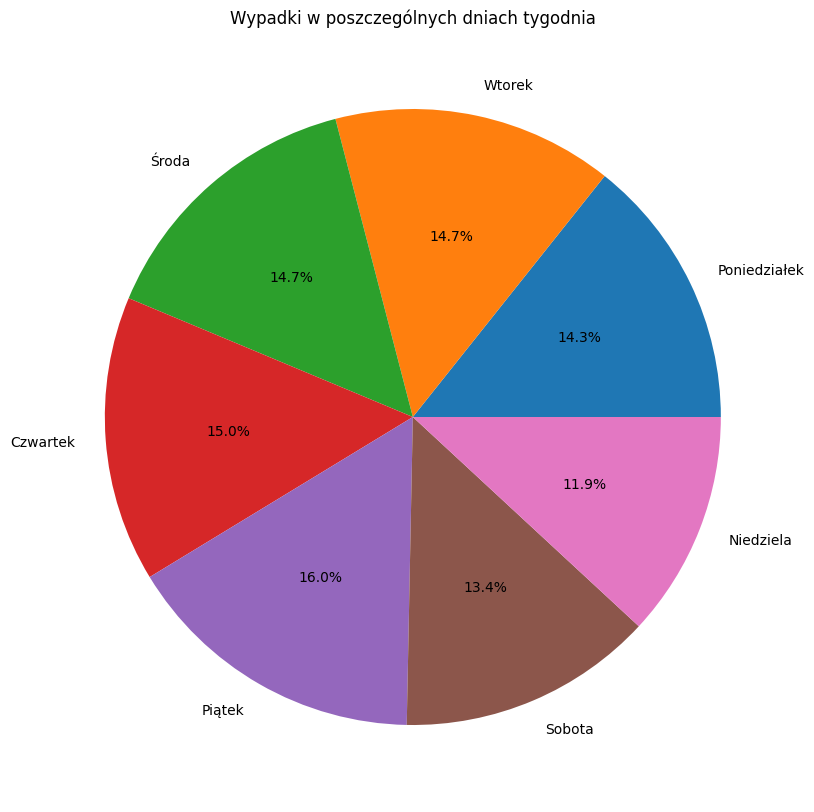

In [17]:
accidents_per_day_of_the_week = combined_data.groupby('Day of the week').sum()
names_of_days = {
    0 : 'Poniedziałek',
    1 : 'Wtorek',
    2 : 'Środa',
    3 : 'Czwartek',
    4 : 'Piątek',
    5 : 'Sobota',
    6 : 'Niedziela'
}

plt.figure(figsize=(10,10))
plt.pie(accidents_per_day_of_the_week['NUMBER OF ACCIDENTS'], labels=list(map(lambda x: names_of_days[x], accidents_per_day_of_the_week.index)), autopct='%1.1f%%')
plt.title('Wypadki w poszczególnych dniach tygodnia')
plt.show()

C:\Users\matig\AppData\Local\Temp\ipykernel_8884\1343592636.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  accidents_per_hour = combined_data.groupby('Hour').sum()


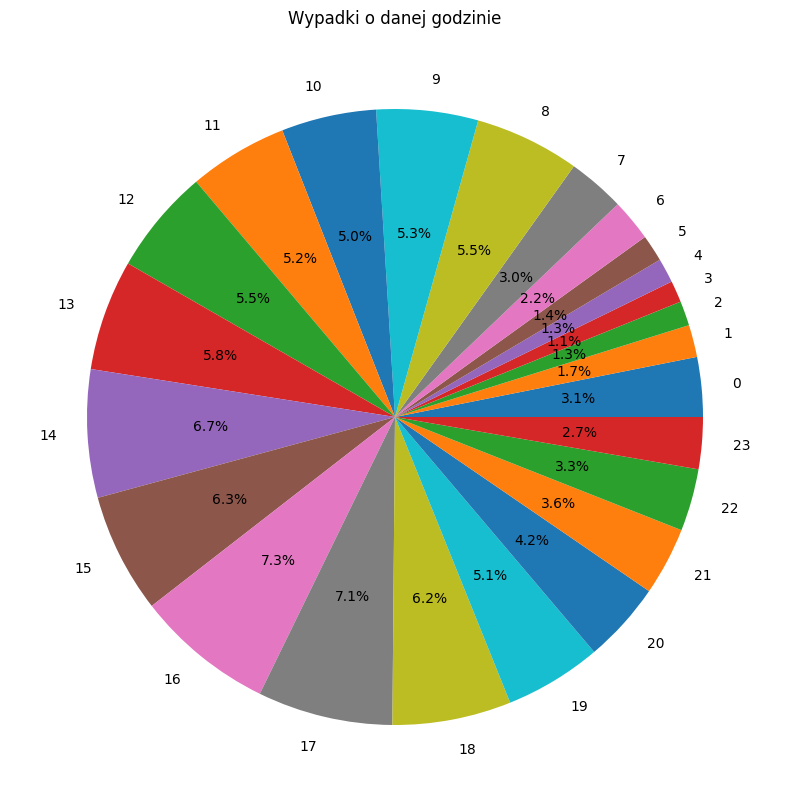

In [18]:
accidents_per_hour = combined_data.groupby('Hour').sum()

plt.figure(figsize=(10,10))
plt.pie(accidents_per_hour['NUMBER OF ACCIDENTS'], labels=accidents_per_hour.index, autopct='%1.1f%%')
plt.title('Wypadki o danej godzinie')
plt.show()

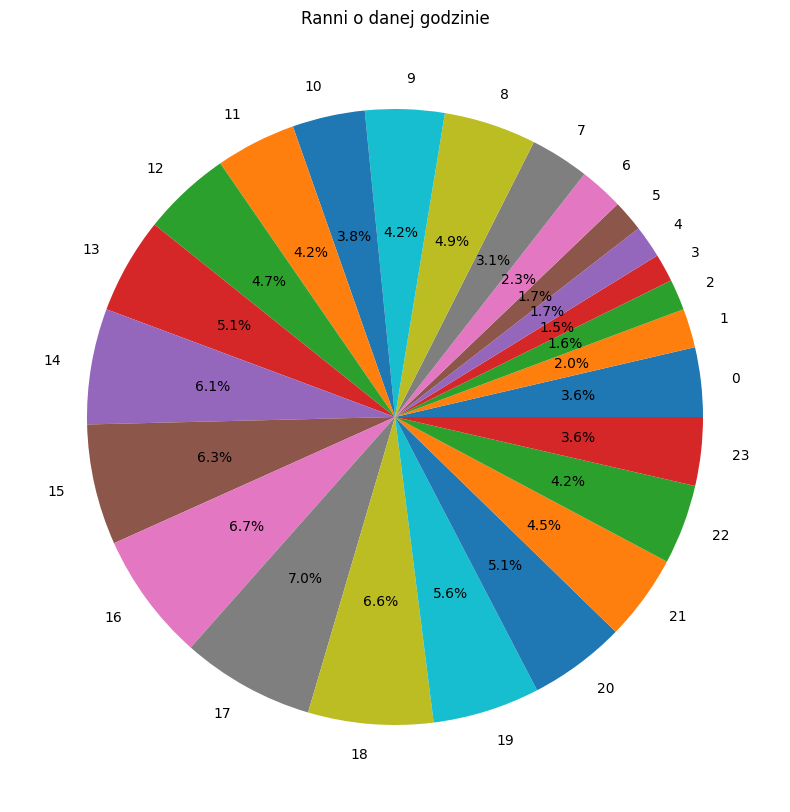

In [19]:
plt.figure(figsize=(10,10))
plt.pie(accidents_per_hour['NUMBER OF PERSONS INJURED'], labels=accidents_per_hour.index, autopct='%1.1f%%')
plt.title('Ranni o danej godzinie')
plt.show()

C:\Users\matig\AppData\Local\Temp\ipykernel_8884\2782176744.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_per_condition = combined_data.groupby('Condition').sum().sort_values(by='NUMBER OF ACCIDENTS', ascending=False)


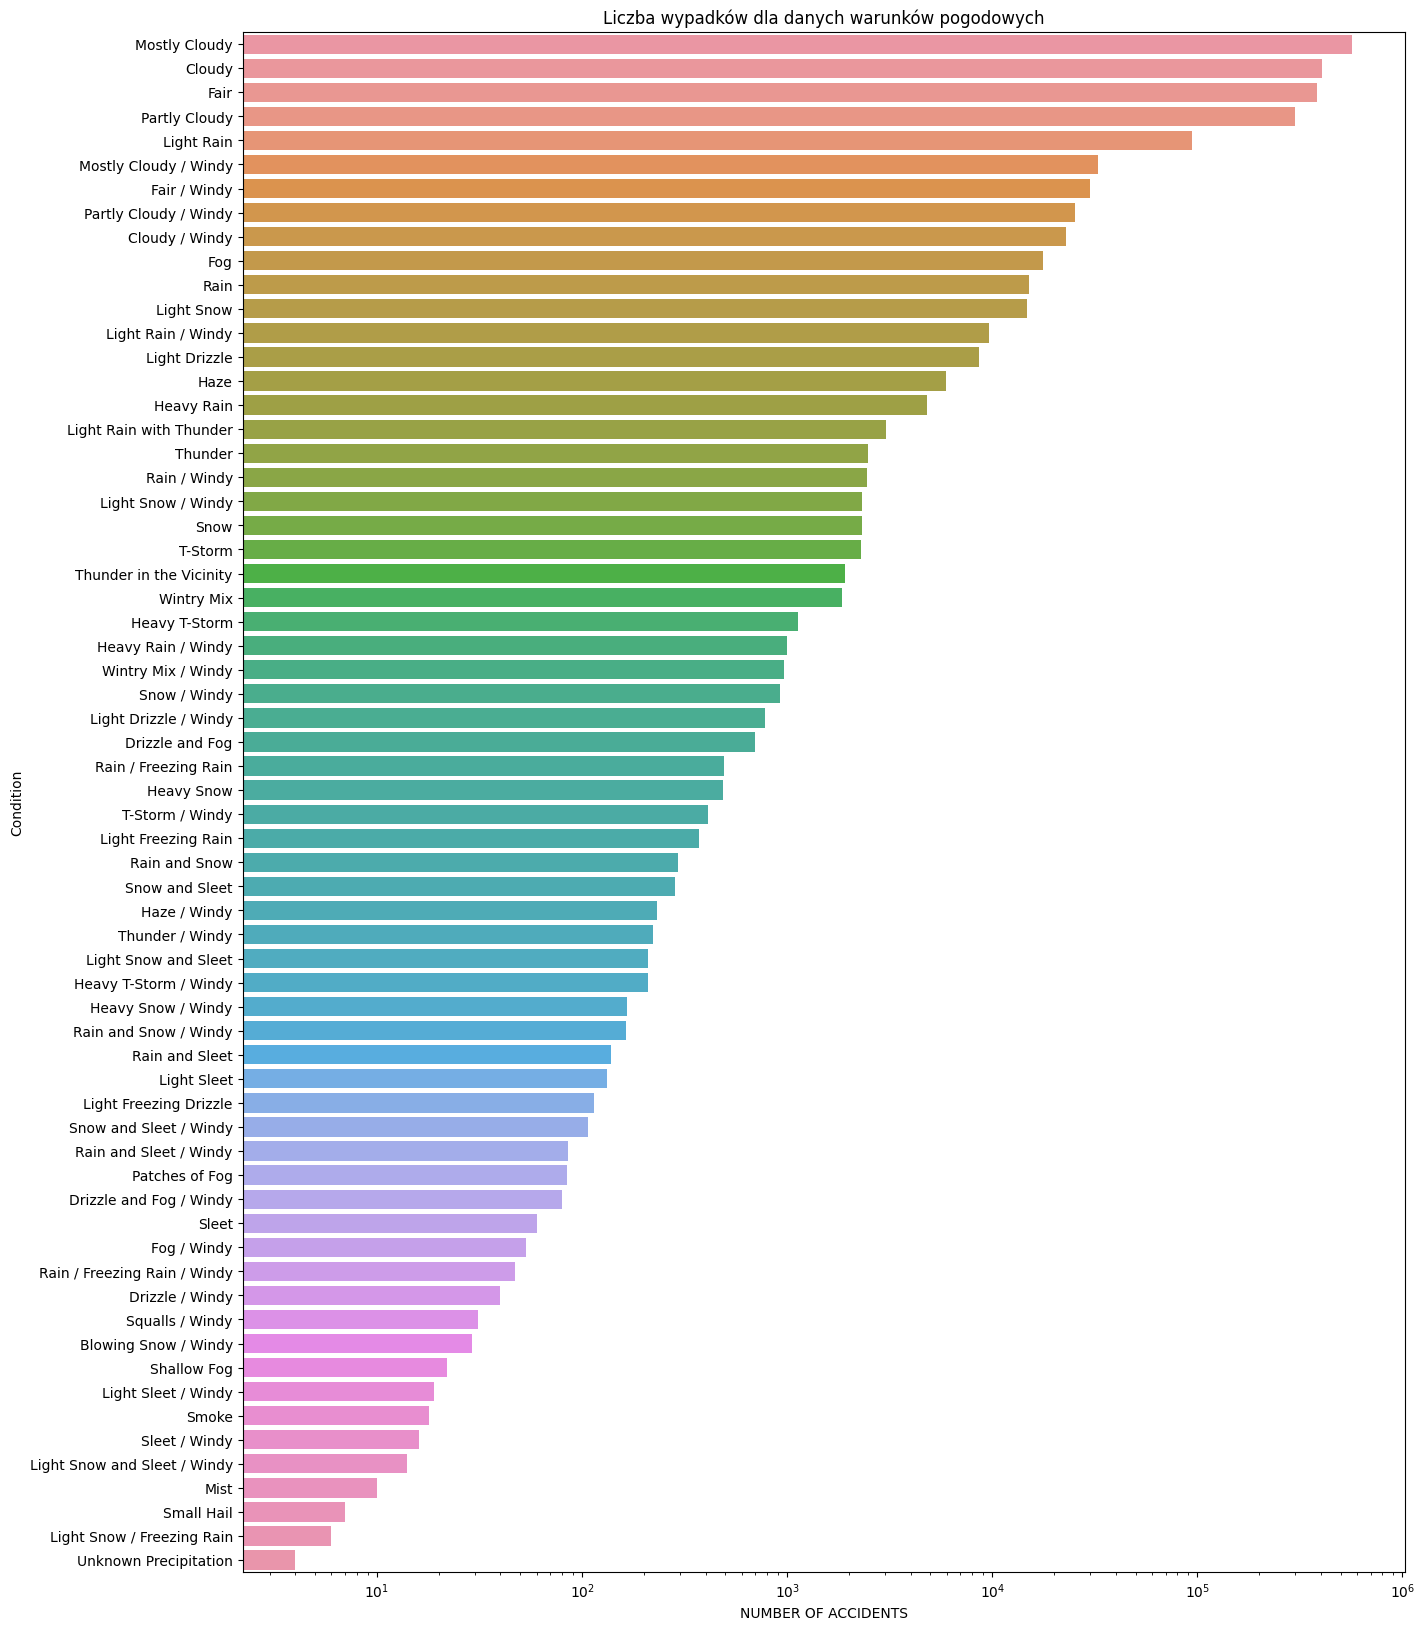

In [20]:
sum_per_condition = combined_data.groupby('Condition').sum().sort_values(by='NUMBER OF ACCIDENTS', ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x = 'NUMBER OF ACCIDENTS',
             y = sum_per_condition.index,
             data = sum_per_condition)

plt.title('Liczba wypadków dla danych warunków pogodowych')
plt.xscale('log')
plt.show()

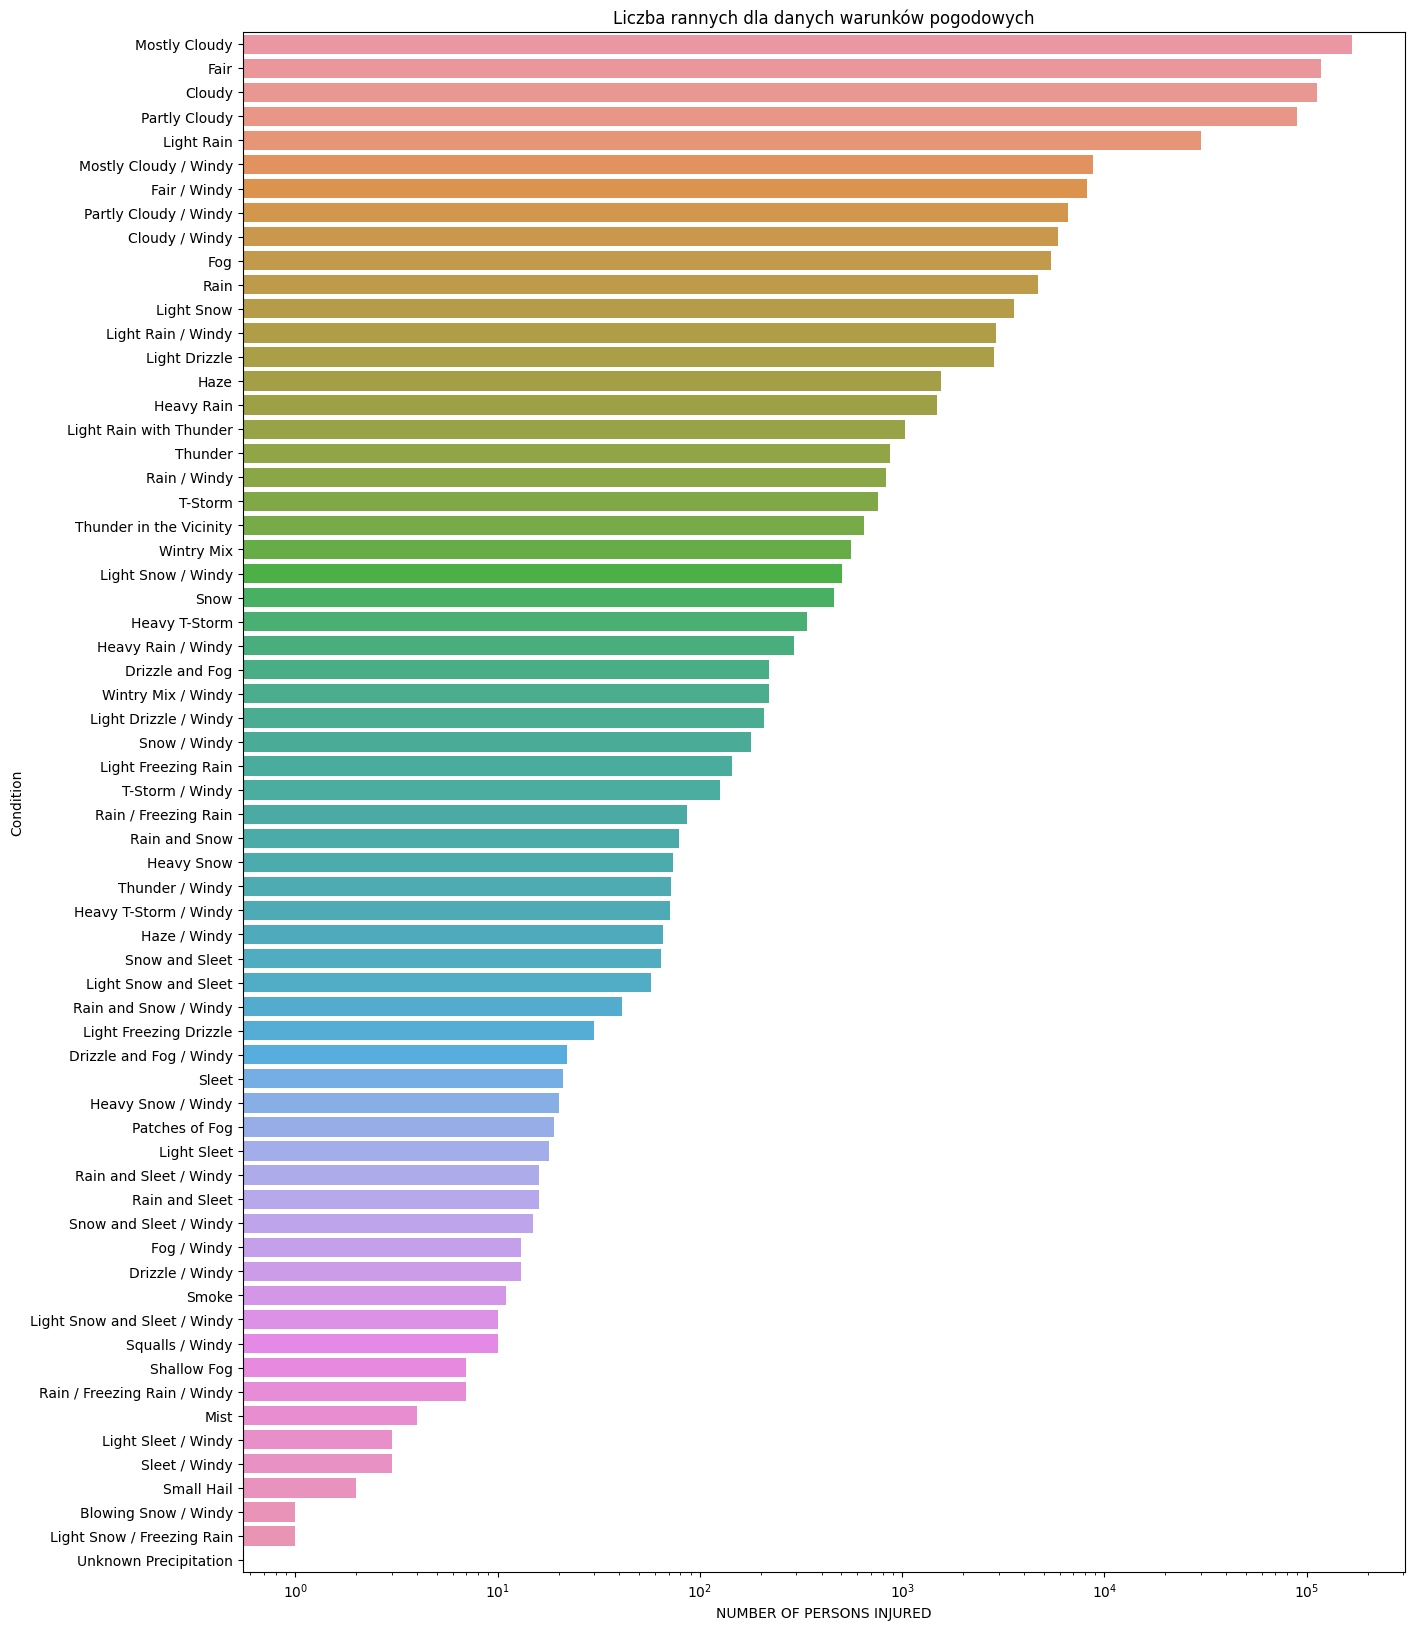

In [21]:
sum_per_condition.sort_values(by='NUMBER OF PERSONS INJURED', inplace=True, ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x = sum_per_condition['NUMBER OF PERSONS INJURED'],
             y = sum_per_condition.index,
            )

plt.title('Liczba rannych dla danych warunków pogodowych')
plt.xscale('log')
plt.show()

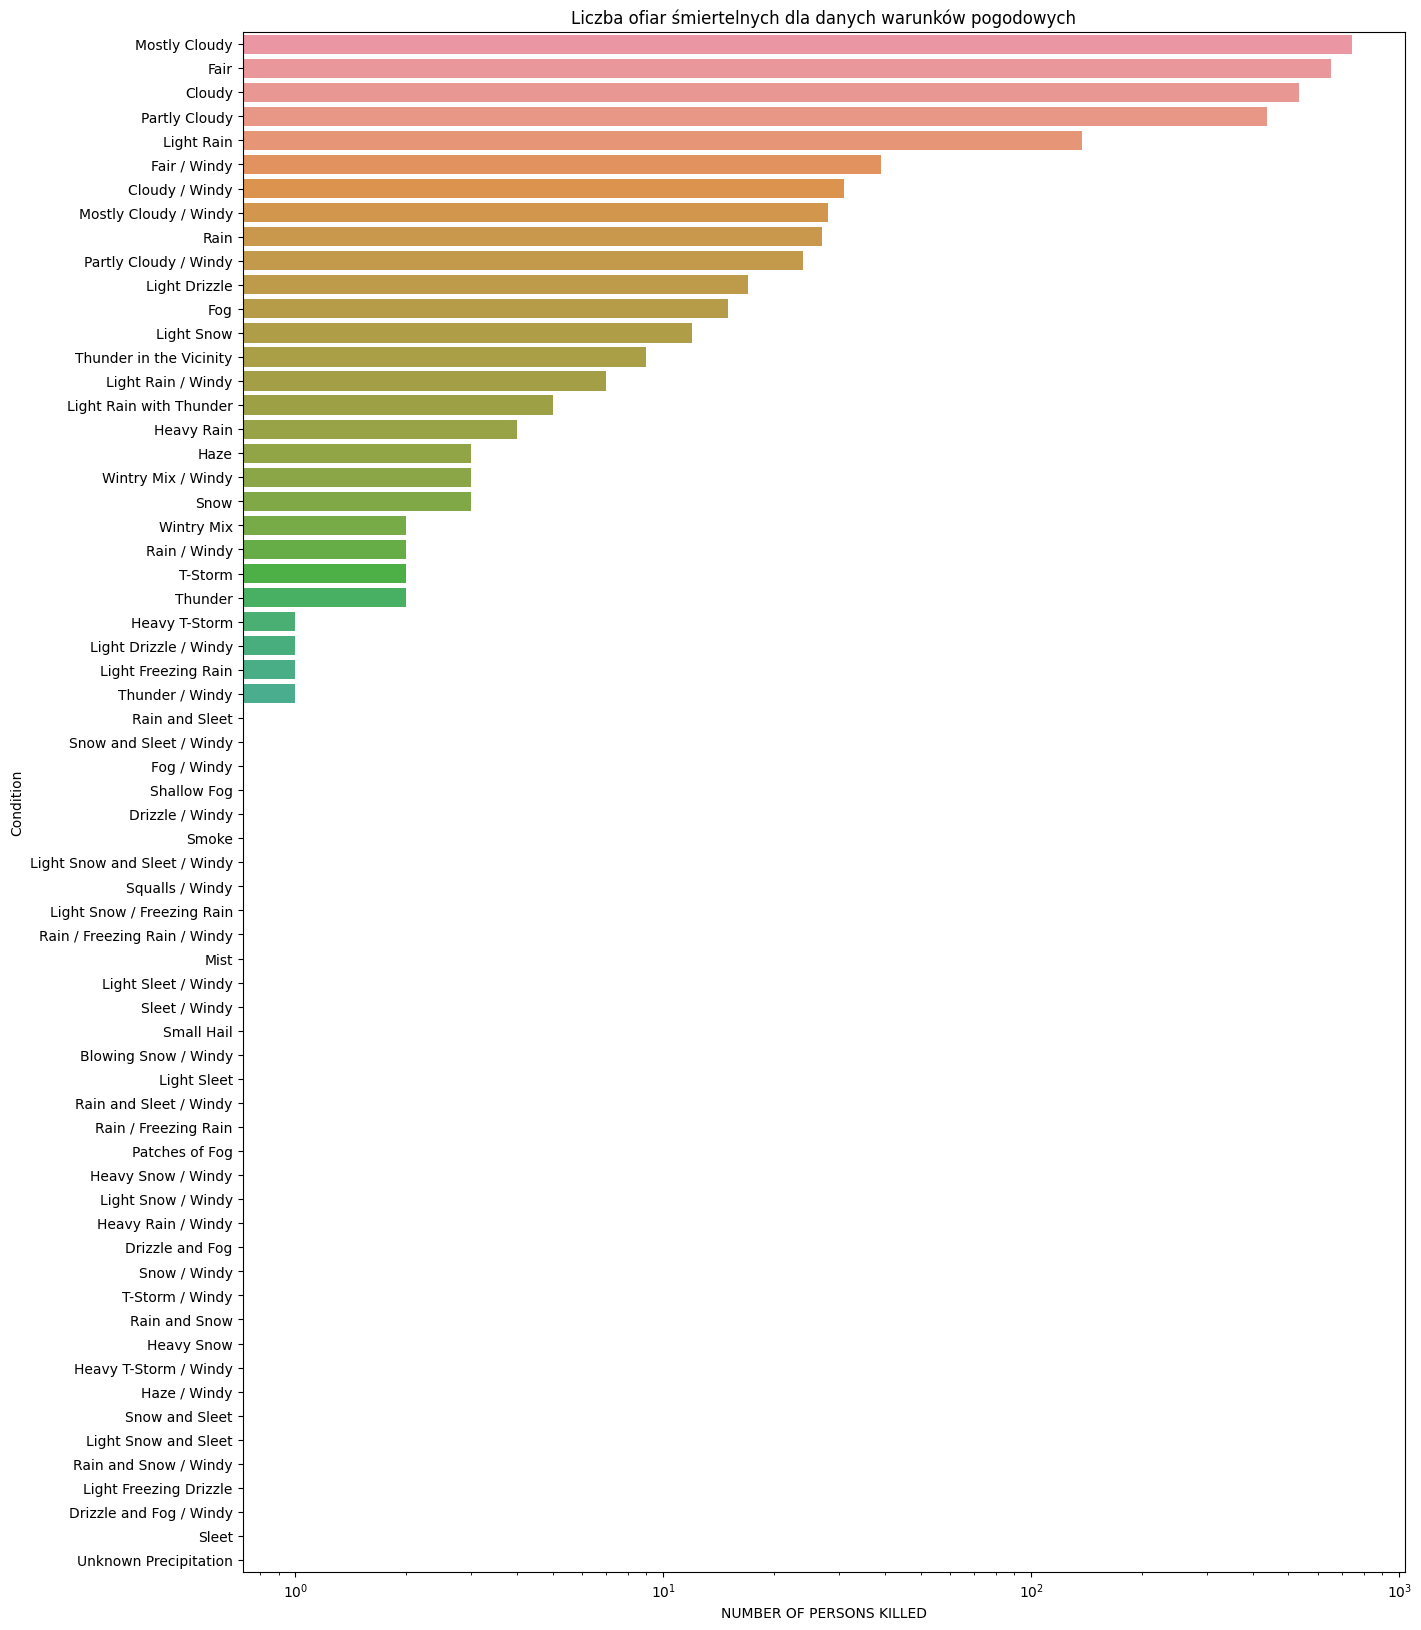

In [22]:
sum_per_condition.sort_values(by='NUMBER OF PERSONS KILLED', inplace=True, ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x = sum_per_condition['NUMBER OF PERSONS KILLED'],
             y = sum_per_condition.index,
            )

plt.title('Liczba ofiar śmiertelnych dla danych warunków pogodowych')
plt.xscale('log')
plt.show()

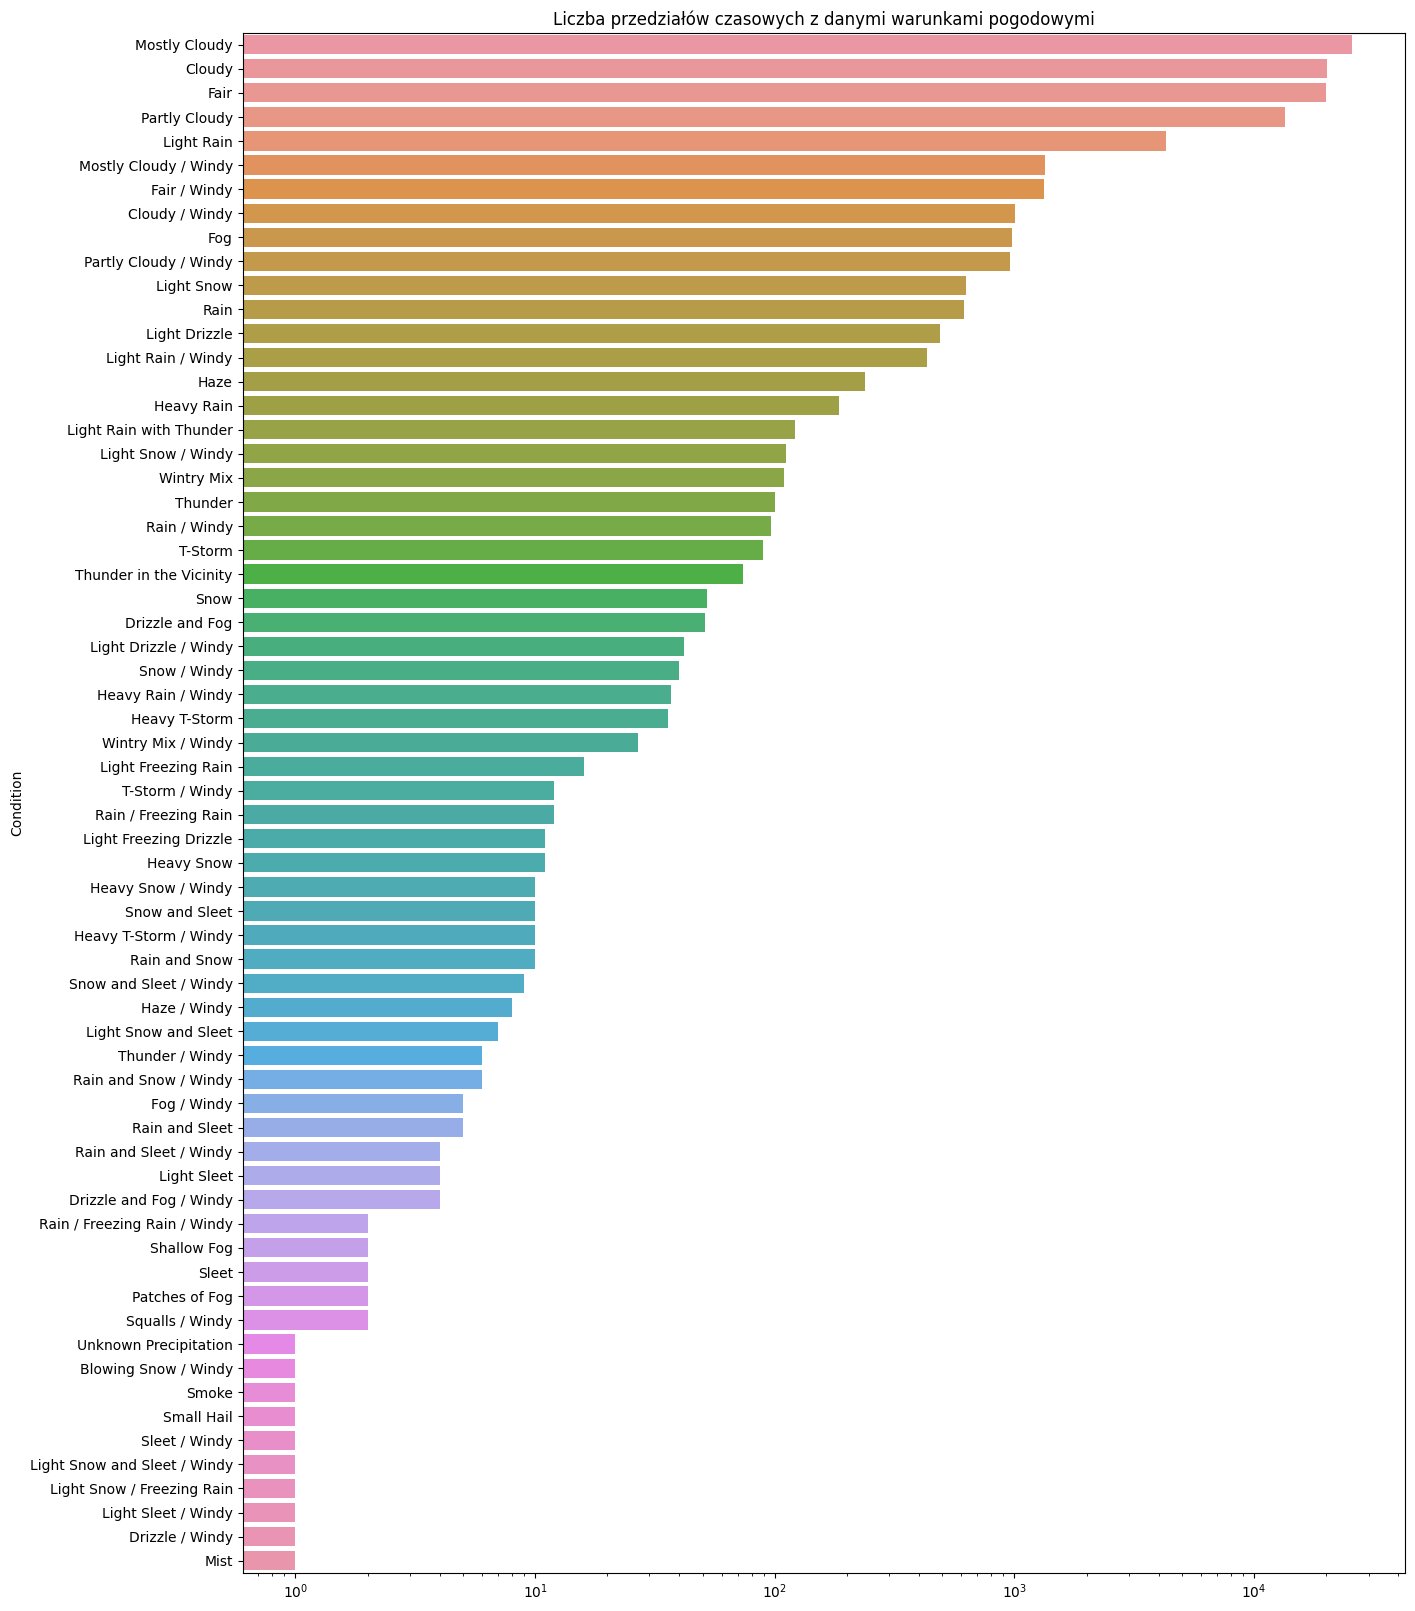

In [23]:
weather_conditon_occurences = combined_data.groupby('Condition').size().sort_values(ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x = weather_conditon_occurences.values,
             y = weather_conditon_occurences.index,
             )

plt.title('Liczba przedziałów czasowych z danymi warunkami pogodowymi')
plt.xscale('log')
plt.show()

C:\Users\matig\AppData\Local\Temp\ipykernel_8884\1034267647.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_condition = combined_data.groupby('Condition').mean().sort_values(by='NUMBER OF ACCIDENTS', ascending=False)


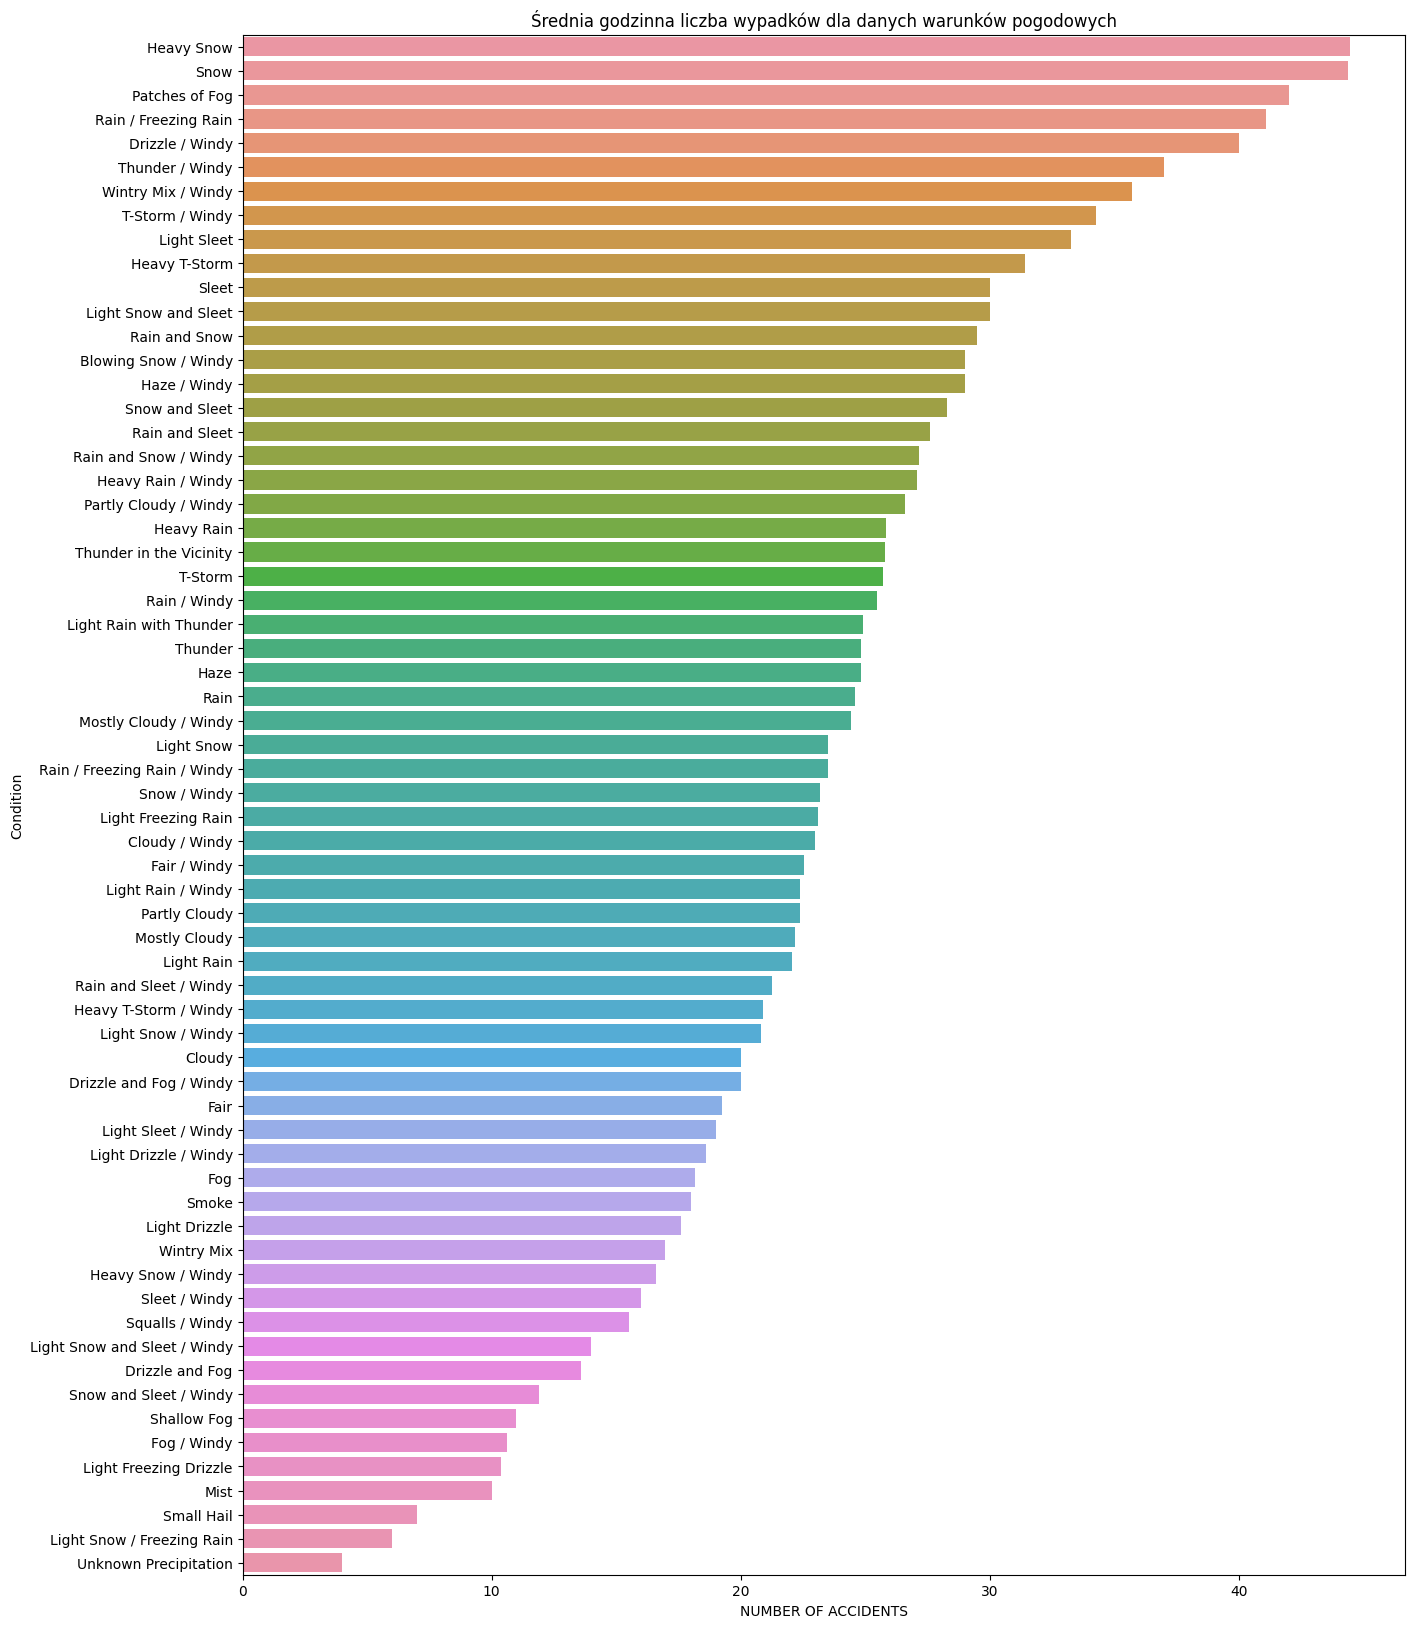

In [24]:
mean_by_condition = combined_data.groupby('Condition').mean().sort_values(by='NUMBER OF ACCIDENTS', ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x = mean_by_condition['NUMBER OF ACCIDENTS'],
             y = mean_by_condition.index,
             )

plt.title('Średnia godzinna liczba wypadków dla danych warunków pogodowych')
plt.xscale('linear')
plt.show()

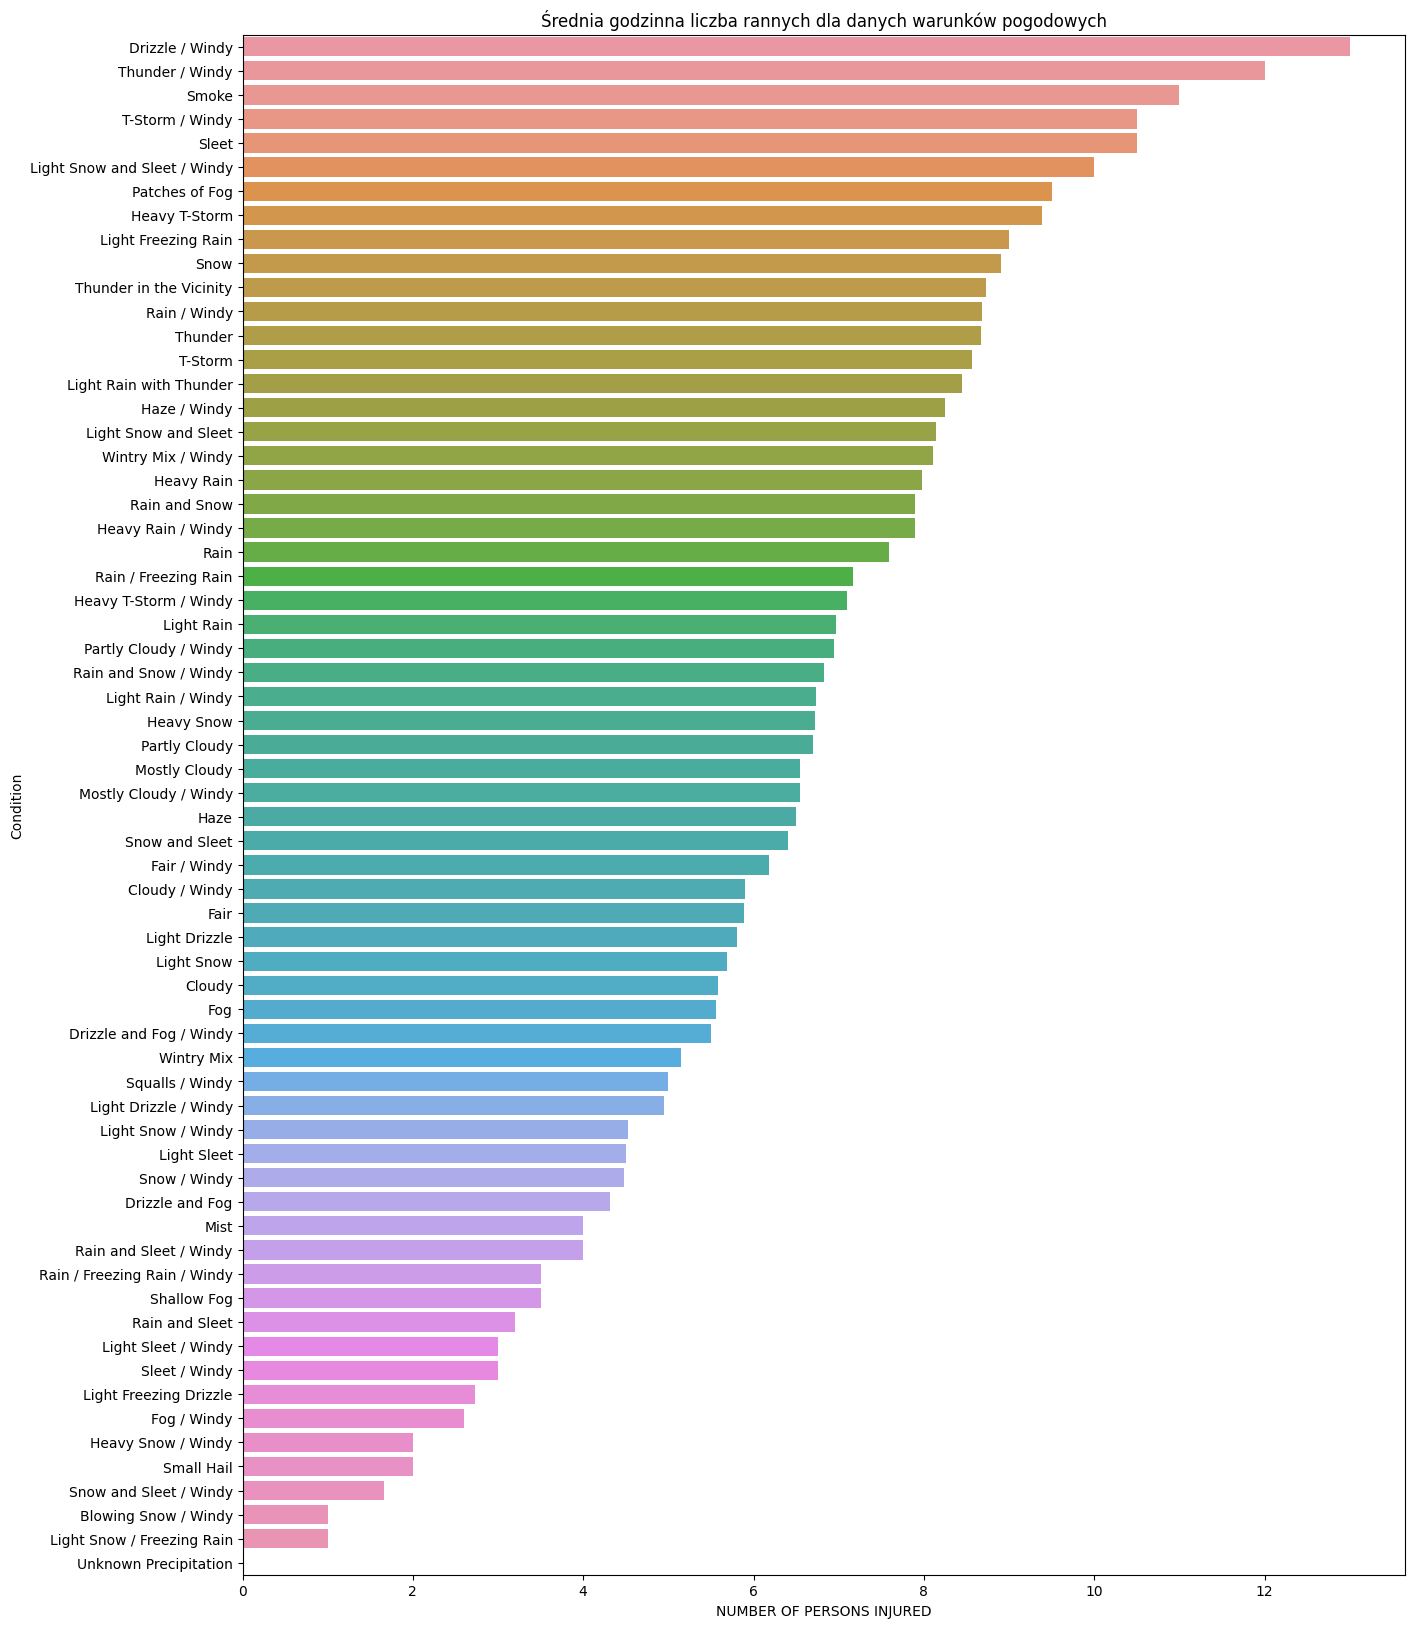

In [25]:
mean_by_condition.sort_values(by='NUMBER OF PERSONS INJURED', inplace=True, ascending=False)


plt.figure(figsize=(15,20))
sns.barplot(x = mean_by_condition['NUMBER OF PERSONS INJURED'],
             y = mean_by_condition.index,
             )

plt.title('Średnia godzinna liczba rannych dla danych warunków pogodowych')
plt.xscale('linear')
plt.show()

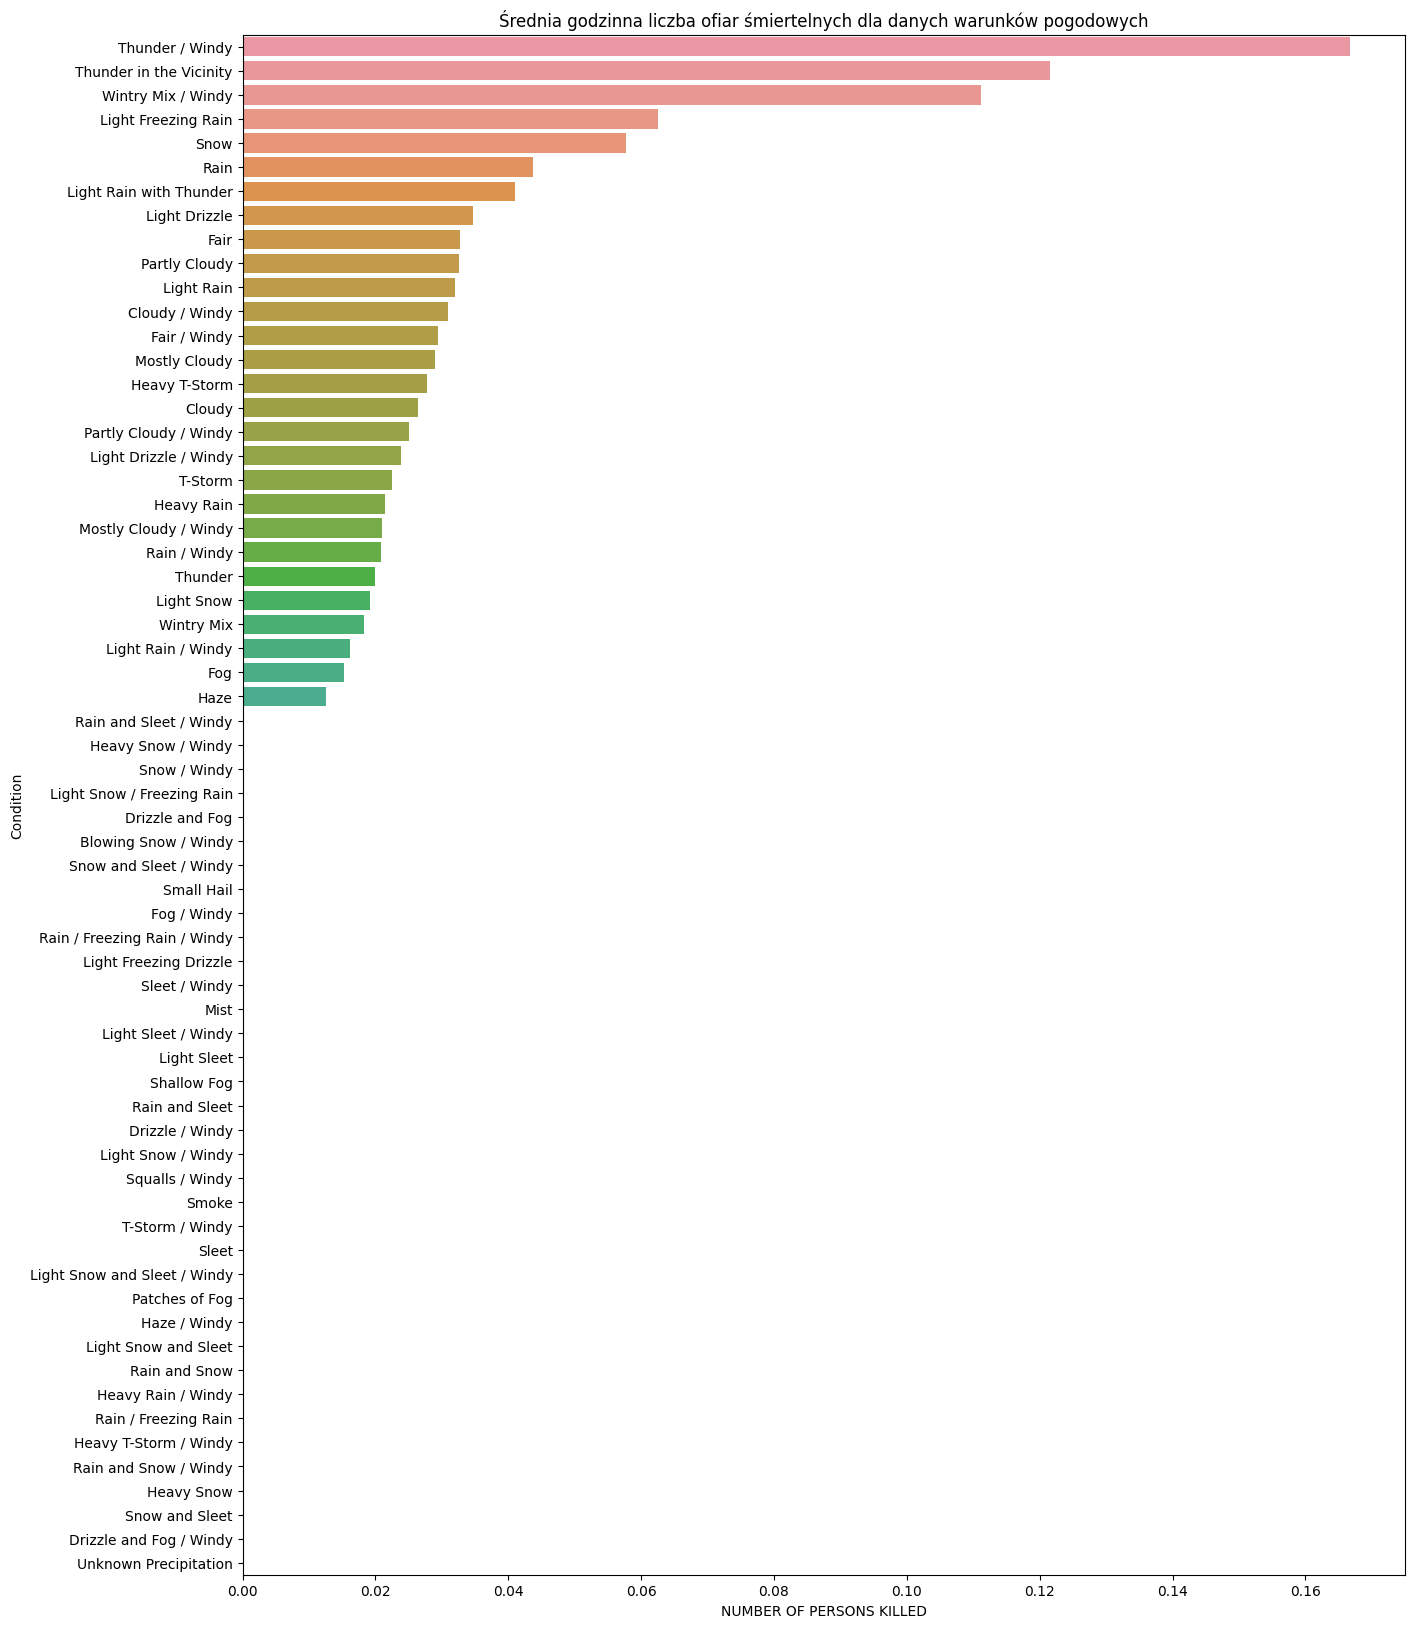

In [26]:
mean_by_condition.sort_values(by='NUMBER OF PERSONS KILLED', inplace=True, ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x = mean_by_condition['NUMBER OF PERSONS KILLED'],
             y = mean_by_condition.index,
             )

plt.title('Średnia godzinna liczba ofiar śmiertelnych dla danych warunków pogodowych')
plt.xscale('linear')
plt.show()

C:\Users\matig\AppData\Local\Temp\ipykernel_8884\1508904684.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(combined_data.corr(),linewidths=.5, annot=True)


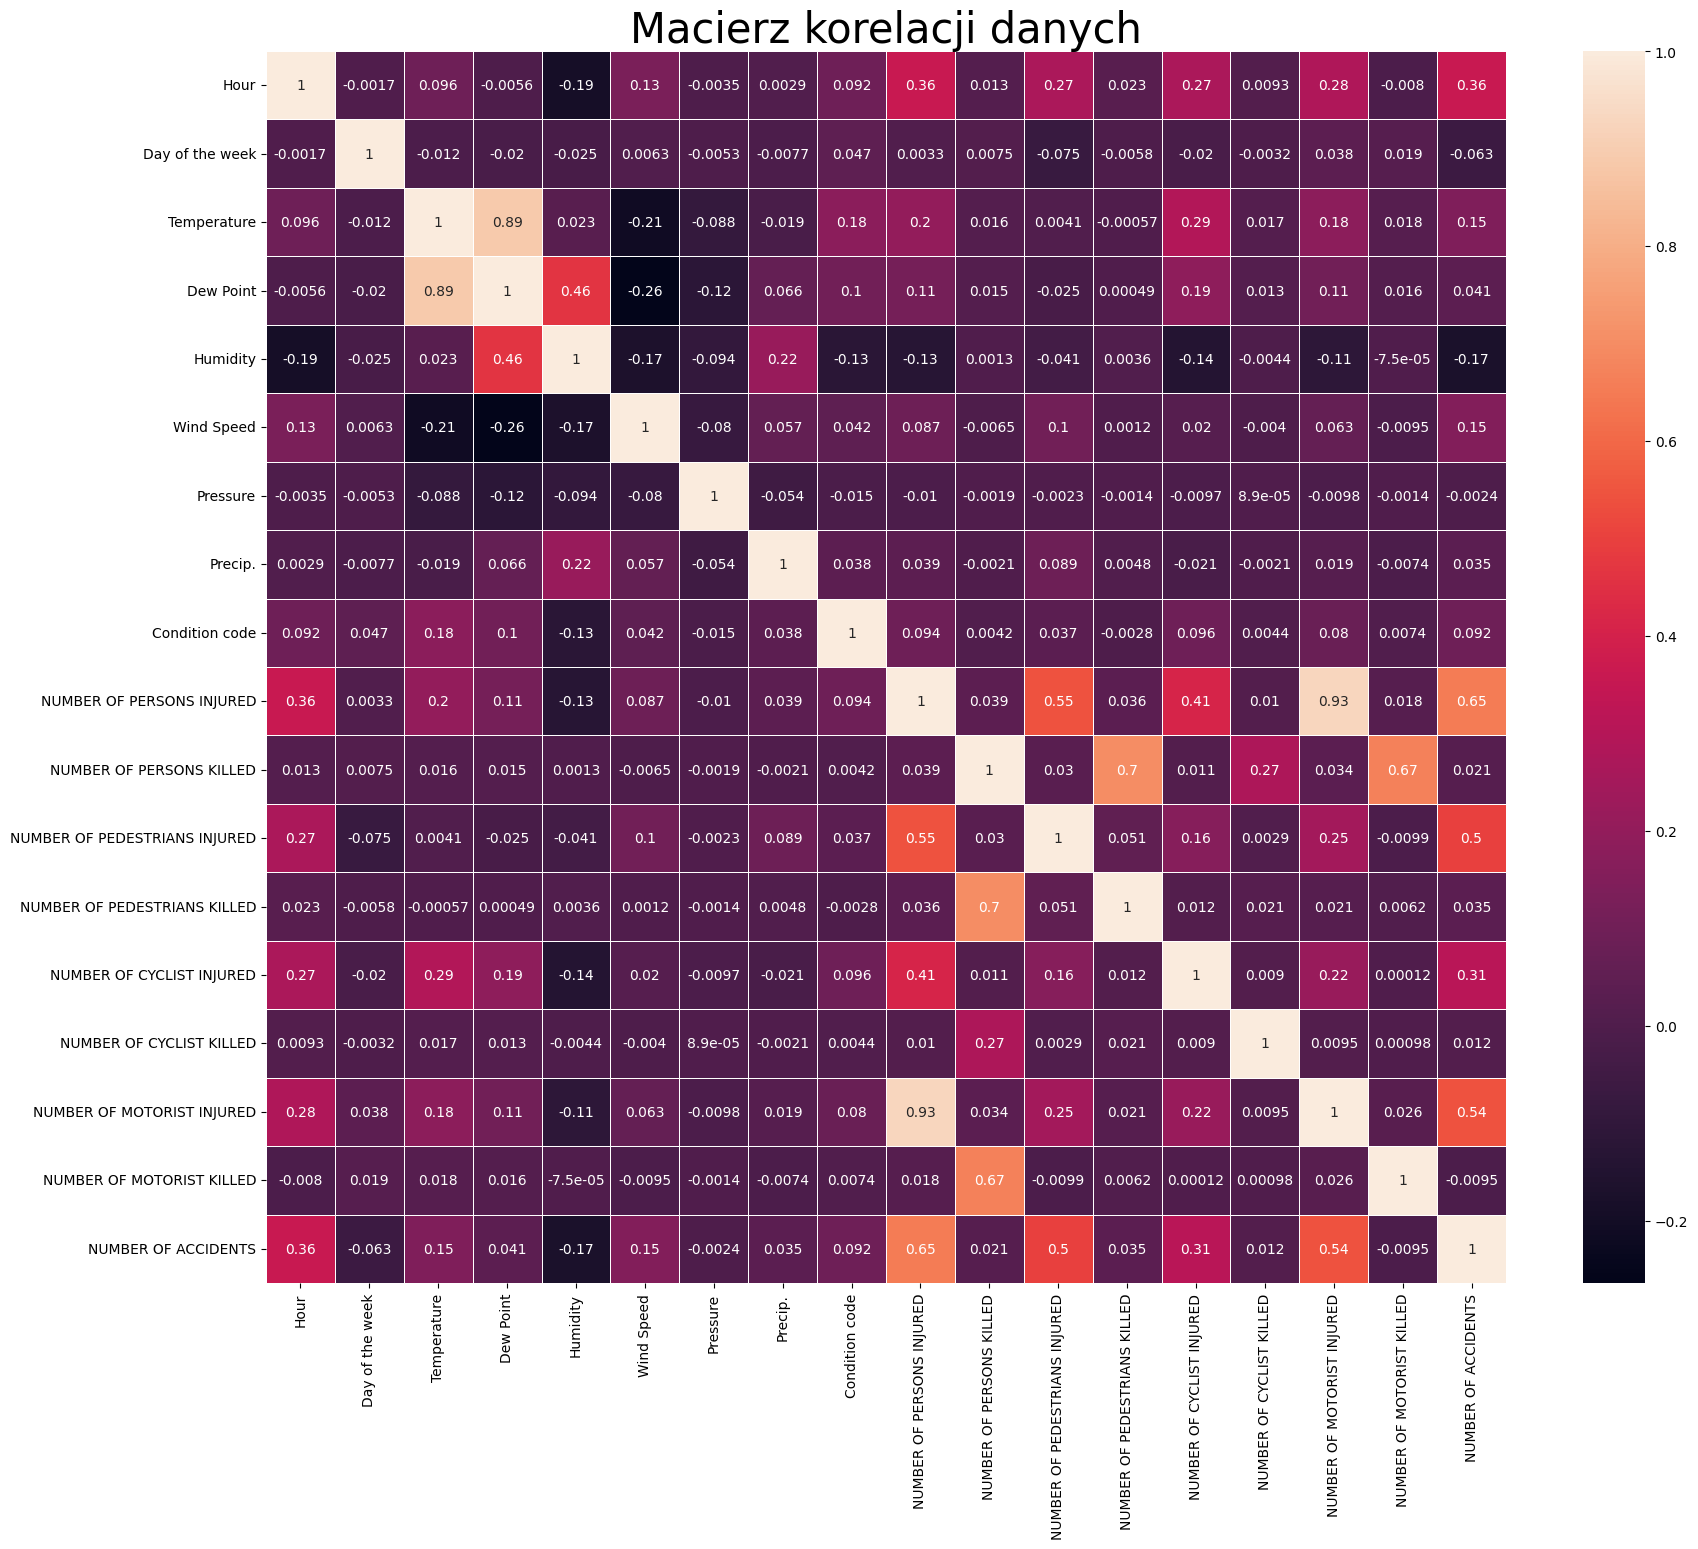

In [27]:
plt.figure(figsize=(20,16))
sns.heatmap(combined_data.corr(),linewidths=.5, annot=True)
plt.yticks(rotation=360)
plt.title('Macierz korelacji danych', fontsize = 30)
plt.show()

Usuwanie danych nienadających się do uwzględnienia w modelach.

In [28]:
data_for_analysis = combined_data.drop(columns=['Timestamp', 'Condition'])

# Podział na dane treningowe i testowe

In [29]:
def split_data(data):
    X = data.loc[:, :'Condition code']
    Y = data.loc[:, 'NUMBER OF PERSONS INJURED':'NUMBER OF ACCIDENTS']

    return train_test_split(X, Y, random_state=834434, train_size=0.75)

X_train, X_test, Y_train, Y_test = split_data(data_for_analysis)

# Modele

Skorzystamy z modelu regresji liniowej `LinearRegression` oraz z `PolynomialFeatures` z biblioteki `scikit-learn` w celu stworzenia uogólnionego modelu regresji.

Model regresji liniowej zakłada liniową zależność między zmiennymi niezależnymi, a zmienną zależną. Model `LinearRegression` dopasowuje prostą regresji liniowej do danych treningowych za pomocą metody najmniejszych kwadratów. Dzięki wykorzystaniu `PolynomialFeatures` zamiast prostej, możemy dopasowywać wielomiany wyższych stopni.

Najpierw dobierzemy odpowiedni stopień wielomianu, dla którego otrzymamy najlepsze wyniki.
Za początkowy wskaźnik oceny modelu posłuży nam współczynnik determinacji R^2, który pokazuje nam jak dobrze model jest dopasowany do danych, czym bliżej wartości 1.0 tym lepiej.

In [30]:
model_scores = pd.DataFrame(columns=range(1, 5))
model_scores.index.name = 'Predicted data'

for column in Y_test.columns:
    score_list = []
    
    for degree in range(1, 5):
        model = LinearRegression()
        pol_feat = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)

        model.fit(pol_feat.fit_transform(X_train), Y_train[column])
        score_list.append(model.score(pol_feat.fit_transform(X_test), Y_test[column]))
    
    model_scores.loc[column] = score_list


model_scores

,1,2,3,4
Predicted data,,,,
NUMBER OF PERSONS INJURED,0.174865,0.180920,-0.135320,-874.261164
NUMBER OF PERSONS KILLED,0.000369,-0.001052,-2.823215,-173.065275
NUMBER OF PEDESTRIANS INJURED,0.096076,0.125276,-0.060100,-660.566032
NUMBER OF PEDESTRIANS KILLED,0.001195,-0.010803,-3.194683,-70.581429
NUMBER OF CYCLIST INJURED,0.156451,0.159790,-1.516552,-55.502386
NUMBER OF CYCLIST KILLED,0.000055,-0.001180,-1.465744,-161.829083
NUMBER OF MOTORIST INJURED,0.114844,0.114614,-0.051060,-631.072011
NUMBER OF MOTORIST KILLED,0.000551,-0.000429,-0.068240,-86.416565
NUMBER OF ACCIDENTS,0.183575,0.330818,-0.716101,-49.843611


Dla modeli predykujących liczbę poszczególnych ofiar śmiertelnych nie otrzymaliśmy satysfakcjonujących wyników dla żadnego stopnia wielomianu. W dalszej części pominiemy te dane, uznając je za niemożliwe do predykowania na podstawie posiadanych danych. Dla reszty danych najlepsze współczynniki R^2 otrzymaliśmy dla wielomianu drugiego stopnia, dalsze obliczenia będziemy kontynuować dla tego właśnie stopnia.

In [31]:
data_for_analysis.drop(columns=['NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED'], inplace=True)

X_train, X_test, Y_train, Y_test = split_data(data_for_analysis)

Dodatkowymi parametrami oceny modelu będą:
+ MSE (mean squared error) - błąd średniokwadratowy, MSE jest wartością oczekiwaną kwadratu błędu, czyli różnicy między estymatorem a wartością estymowaną.
+ MAE (mean absolute error) - średni błąd bezwzględny, średnia bezwzględna różnica między przewidywaniem modelu a wartością docelową.
+ MAPE (mean absolute percentage error) - średni bezwzględny błąd procentowy, średnia wielkość błędów prognoz wyrażona w procentach

In [32]:
def score_models():
    model_scores = pd.DataFrame(columns=['R^2', 'MSE', 'MAE', 'MAPE'])
    model_scores.index.name = 'Predicted data'

    for column in Y_test.columns:
        model = LinearRegression()
        pol_feat = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

        model.fit(pol_feat.fit_transform(X_train), Y_train[column])
        predictions = model.predict(pol_feat.fit_transform(X_test))

        R_squared = model.score(pol_feat.fit_transform(X_test), Y_test[column])
        MSE = mean_squared_error(Y_test[column], predictions)
        MAE = mean_absolute_error(Y_test[column], predictions)
        MAPE = mean_absolute_percentage_error(Y_test[column], predictions)
        
        model_scores.loc[column] = [R_squared, MSE, MAE, MAPE]

    return model_scores

score_models()

,R^2,MSE,MAE,MAPE
Predicted data,,,,
NUMBER OF PERSONS INJURED,0.180920,18.613267,3.266432,1.299319e+15
NUMBER OF PEDESTRIANS INJURED,0.125276,2.047888,0.997222,1.812917e+15
NUMBER OF CYCLIST INJURED,0.159790,0.619836,0.568059,1.254049e+15
NUMBER OF MOTORIST INJURED,0.114614,13.302406,2.756289,1.849806e+15
NUMBER OF ACCIDENTS,0.330818,138.443287,9.307358,8.878276e-01


W celu poprawy wyników spróbujmy podzielić godziny na pory dnia.

In [33]:
modified_data = data_for_analysis.copy(deep=True)

bins = (0, 4, 8, 12, 16, 20, 23)
categories = pd.Categorical(pd.cut(modified_data['Hour'], bins, include_lowest=True)).codes
modified_data.insert(1, 'Time of the day', categories)
modified_data.drop(columns='Hour', inplace=True)
modified_data

,Time of the day,Day of the week,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition code,NUMBER OF PERSONS INJURED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF CYCLIST INJURED,NUMBER OF MOTORIST INJURED,NUMBER OF ACCIDENTS
0,5,0,28,13,41,15,1010.08,0.0,35,8,2,0,6,14
1,0,0,27,12,39,15,1009.78,0.0,35,4,1,2,1,16
2,0,0,27,12,40,11,1010.28,0.0,6,18,0,0,18,14
3,0,0,25,13,48,13,1010.08,0.0,6,0,0,0,0,5
4,0,0,25,13,46,0,1009.98,0.0,6,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92805,4,5,1,-6,64,13,1021.28,0.0,1,2,0,0,2,5
92806,5,5,0,-6,66,11,1021.28,0.0,33,6,0,0,6,12
92807,5,5,-1,-5,72,11,1020.95,0.0,35,1,1,0,0,9
92808,5,5,-1,-6,69,9,1020.61,0.0,6,3,0,0,3,6


Wyniki dla zmodyfikowanych danych.

In [34]:
X_train, X_test, Y_train, Y_test = split_data(modified_data)
score_models()

,R^2,MSE,MAE,MAPE
Predicted data,,,,
NUMBER OF PERSONS INJURED,0.196020,18.270124,3.222515,1.214965e+15
NUMBER OF PEDESTRIANS INJURED,0.133840,2.027836,0.984308,1.767050e+15
NUMBER OF CYCLIST INJURED,0.164005,0.616726,0.564249,1.246057e+15
NUMBER OF MOTORIST INJURED,0.124229,13.157934,2.734353,1.788558e+15
NUMBER OF ACCIDENTS,0.361155,132.167051,8.912290,7.841644e-01


Jak możemy zauważyć wyniki nieco się polepszyły.
W celu dalszego polepszenia wyników zredukujemy liczbę kategorii pogodowych. Zauważmy, że wiele kategorii występuje w dwóch wersjach, różniących się dopiskiem 'Windy'. Dodamy kolumnę 'Is windy', w której będzie 1 jeśli w kategorii danego wpisu występuje 'Windy' oraz 0 w przeciwnym wypadku. Następnie usuniemy dopiski 'Windy' z kategorii pogodowych i przerobimy je spowrotem na wartości numeryczne.

In [35]:
is_windy = combined_data['Condition'].apply(lambda x: 0 if re.search(' / Windy', x) == None else 1)
modified_data.insert(9, 'Is windy', is_windy)
modified_data['Condition code'] = pd.Categorical(combined_data['Condition'].apply(lambda x: re.sub(' / Windy', '', x))).codes
print(f"Liczba różnych kategorii warunków pogodowych: {len(modified_data['Condition code'].unique())}")
modified_data

Liczba różnych kategorii warunków pogodowych: 39


,Time of the day,Day of the week,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Precip.,Condition code,Is windy,NUMBER OF PERSONS INJURED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF CYCLIST INJURED,NUMBER OF MOTORIST INJURED,NUMBER OF ACCIDENTS
0,5,0,28,13,41,15,1010.08,0.0,21,0,8,2,0,6,14
1,0,0,27,12,39,15,1009.78,0.0,21,0,4,1,2,1,16
2,0,0,27,12,40,11,1010.28,0.0,4,0,18,0,0,18,14
3,0,0,25,13,48,13,1010.08,0.0,4,0,0,0,0,0,5
4,0,0,25,13,46,0,1009.98,0.0,4,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92805,4,5,1,-6,64,13,1021.28,0.0,1,0,2,0,0,2,5
92806,5,5,0,-6,66,11,1021.28,0.0,20,0,6,0,0,6,12
92807,5,5,-1,-5,72,11,1020.95,0.0,21,0,1,1,0,0,9
92808,5,5,-1,-6,69,9,1020.61,0.0,4,0,3,0,0,3,6


Wyniki dla zmienionych kategorii.

In [36]:
X = modified_data.loc[:, :'Is windy']
Y = modified_data.loc[:, 'NUMBER OF PERSONS INJURED':'NUMBER OF ACCIDENTS']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=834434, train_size=0.75)

score_models()

,R^2,MSE,MAE,MAPE
Predicted data,,,,
NUMBER OF PERSONS INJURED,0.189968,18.407652,3.223606,1.215275e+15
NUMBER OF PEDESTRIANS INJURED,0.128599,2.040107,0.984621,1.767171e+15
NUMBER OF CYCLIST INJURED,0.163809,0.616871,0.564221,1.245626e+15
NUMBER OF MOTORIST INJURED,0.120199,13.218494,2.734905,1.791044e+15
NUMBER OF ACCIDENTS,0.355893,133.255614,8.914296,7.842595e-01


Następnie sprawdźmy wyniki dla przeskalowanych danych.

In [37]:
X = modified_data.loc[:, :'Is windy']
Y = modified_data.loc[:, 'NUMBER OF PERSONS INJURED':'NUMBER OF ACCIDENTS']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=834434, train_size=0.75)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

score_models()

,R^2,MSE,MAE,MAPE
Predicted data,,,,
NUMBER OF PERSONS INJURED,0.189969,18.407650,3.223602,1.215267e+15
NUMBER OF PEDESTRIANS INJURED,0.128599,2.040107,0.984615,1.767125e+15
NUMBER OF CYCLIST INJURED,0.163809,0.616871,0.564219,1.245611e+15
NUMBER OF MOTORIST INJURED,0.120199,13.218494,2.734906,1.791048e+15
NUMBER OF ACCIDENTS,0.355893,133.255596,8.914292,7.842571e-01


In [38]:
X = modified_data.loc[:, :'Is windy']
Y = modified_data.loc[:, 'NUMBER OF PERSONS INJURED':'NUMBER OF ACCIDENTS']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=834434, train_size=0.75)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

score_models()

,R^2,MSE,MAE,MAPE
Predicted data,,,,
NUMBER OF PERSONS INJURED,0.189968,18.407652,3.223606,1.215275e+15
NUMBER OF PEDESTRIANS INJURED,0.128599,2.040107,0.984621,1.767171e+15
NUMBER OF CYCLIST INJURED,0.163809,0.616871,0.564221,1.245626e+15
NUMBER OF MOTORIST INJURED,0.120199,13.218494,2.734905,1.791044e+15
NUMBER OF ACCIDENTS,0.355893,133.255614,8.914296,7.842595e-01


Po podzieleniu kategorii wyniki nieco się pogorszyły, względem zmodyfikowanych danych z wyłącznie wprowadzonymi porami dnia. Były one jednak lepsze niż dane przed modyfikacjami. Skalowanie danych nie wpłynęło na wyniki.

In [39]:
X = modified_data.loc[:, :'Is windy']
Y = modified_data.loc[:, 'NUMBER OF PERSONS INJURED':'NUMBER OF ACCIDENTS']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=834434, train_size=0.75)

model_scores = pd.DataFrame(columns=['Predicted data', 'Without parameter', 'R^2', 'MSE', 'MAE', 'MAPE']) 

for column in Y_test.columns:
    for parameter in X.columns:
        model = LinearRegression()
        pol_feat = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

        model.fit(pol_feat.fit_transform(X_train.drop(columns=parameter)), Y_train[column])
        predictions = model.predict(pol_feat.fit_transform(X_test.drop(columns=parameter)))

        R_squared = model.score(pol_feat.fit_transform(X_test.drop(columns=parameter)), Y_test[column])
        MSE = mean_squared_error(Y_test[column], predictions)
        MAE = mean_absolute_error(Y_test[column], predictions)
        MAPE = mean_absolute_percentage_error(Y_test[column], predictions)
        
        model_scores.loc[len(model_scores)] = [column, parameter, R_squared, MSE, MAE, MAPE]

model_scores.set_index(['Predicted data', 'Without parameter'], inplace=True)
model_scores

R^2         MSE  \
Predicted data                Without parameter                         
NUMBER OF PERSONS INJURED     Time of the day    0.037882   21.863754   
                              Day of the week    0.187109   18.472625   
                              Temperature        0.207475   18.009821   
                              Dew Point          0.206982   18.021033   
                              Humidity           0.205654   18.051207   
                              Wind Speed         0.189022   18.429159   
                              Pressure           0.204391   18.079897   
                              Precip.            0.205256   18.060243   
                              Condition code     0.198821   18.206483   
                              Is windy           0.195553   18.280750   
NUMBER OF PEDESTRIANS INJURED Time of the day   -0.010877    2.366645   
                              Day of the week    0.116420    2.068620   
                              Temperature        0.144362    2.003202   
                              Dew Point          0.143887    2.004315   
                              Humidity           0.141019    2.011029   
                              Wind Speed         0.126794    2.044334   
                              Pressure           0.142381    2.007840   
                              Precip.            0.128185    2.041077   
                              Condition code     0.135313    2.024388   
                              Is windy           0.133550    2.028516   
NUMBER OF CYCLIST INJURED     Time of the day    0.105875    0.659610   
                              Day of the week    0.161734    0.618402   
                              Temperature        0.176703    0.607359   
                              Dew Point          0.177221    0.606977   
                              Humidity           0.177221    0.606977   
                              Wind Speed         0.166227    0.615087   
                              Pressure           0.176114    0.607793   
                              Precip.            0.165139    0.615890   
                              Condition code     0.171017    0.611554   
                              Is windy           0.163921    0.616788   
NUMBER OF MOTORIST INJURED    Time of the day    0.038930   14.439511   
                              Day of the week    0.117715   13.255803   
                              Temperature        0.127805   13.104210   
                              Dew Point          0.127445   13.109614   
                              Humidity           0.126747   13.120111   
                              Wind Speed         0.119405   13.230416   
                              Pressure           0.125995   13.131414   
                              Precip.            0.133989   13.011300   
                              Condition code     0.124363   13.155926   
                              Is windy           0.123936   13.162336   
NUMBER OF ACCIDENTS           Time of the day    0.090108  188.242386   
                              Day of the week    0.344318  135.650341   
                              Temperature        0.363918  131.595363   
                              Dew Point          0.363284  131.726539   
                              Humidity           0.360986  132.201981   
                              Wind Speed         0.353872  133.673755   
                              Pressure           0.362460  131.897163   
                              Precip.            0.362974  131.790750   
                              Condition code     0.363604  131.660378   
                              Is windy           0.360838  132.232592   

                                                       MAE          MAPE  
Predicted data                Without parameter                           
NUMBER OF PERSONS INJURED     Time of the day     3.540273  1.768475e+15  
                              Da

In [40]:
best_scores = model_scores['R^2'].groupby('Predicted data').idxmax().values

print(f"Parametr nieobecny w najlepszym wyniku R^2:\n{best_scores}", end='\n\n')
print(f"Najlepsze wyniki R^2:\n\n{model_scores['R^2'].groupby('Predicted data').max()}")

Parametr nieobecny w najlepszym wyniku R^2:
[('NUMBER OF ACCIDENTS', 'Temperature')
 ('NUMBER OF CYCLIST INJURED', 'Humidity')
 ('NUMBER OF MOTORIST INJURED', 'Precip.')
 ('NUMBER OF PEDESTRIANS INJURED', 'Temperature')
 ('NUMBER OF PERSONS INJURED', 'Temperature')]

Najlepsze wyniki R^2:

Predicted data
NUMBER OF ACCIDENTS              0.363918
NUMBER OF CYCLIST INJURED        0.177221
NUMBER OF MOTORIST INJURED       0.133989
NUMBER OF PEDESTRIANS INJURED    0.144362
NUMBER OF PERSONS INJURED        0.207475
Name: R^2, dtype: float64


In [41]:
model_scores.loc[best_scores]

,,R^2,MSE,MAE,MAPE
Predicted data,Without parameter,,,,
NUMBER OF ACCIDENTS,Temperature,0.363918,131.595363,8.906754,7.831794e-01
NUMBER OF CYCLIST INJURED,Humidity,0.177221,0.606977,0.563631,1.243361e+15
NUMBER OF MOTORIST INJURED,Precip.,0.133989,13.011300,2.733827,1.782298e+15
NUMBER OF PEDESTRIANS INJURED,Temperature,0.144362,2.003202,0.984191,1.769910e+15
NUMBER OF PERSONS INJURED,Temperature,0.207475,18.009821,3.219689,1.213232e+15


Pomimo zabiegów zwiększających precyzję modelów, po wynikach wskaźników oceniających modele, należy stwierdzić, że na podstawie posiadanych danych pogodowych nie jesteśmy wstanie trafnie przewidywać danych o wypadkach.

Procentowy udział średniego błędu bezwzględnego w średniej wartości godzinej liczby wypadków:

In [42]:
model_scores.loc['NUMBER OF ACCIDENTS'].loc['Temperature', 'MAE'] / modified_data['NUMBER OF ACCIDENTS'].mean() * 100

42.00182581451117

Nawet dla najlepszego modelu (model prognozujący godzinną liczbę wypadków bez korzystania z temperatury) średni błąd bezwzględny prognozowanej wielkości stanowi około 42% średniej wartośći tej wielkości.